In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
device_id = 1
device_name = f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device(device_name)
print('Using {} device'.format(DEVICE))

Using cuda:1 device


In [ ]:
def generate_mixture_samples(means, covariances, pi, num_samples):
    """
    Generate samples from a mixture of Gaussians.

    Parameters:
    - means: (K, d) array of means for K Gaussian components
    - covariances: (K, d, d) array of covariance matrices for K Gaussian components
    - weights: (K,) array of weights for K Gaussian components
    - num_samples: Total number of samples to generate

    Returns:
    - X_np: (num_samples, d) array of generated samples
    """
    K = len(pi)  # Number of Gaussian components
    d = means.shape[1]  # Dimensionality of the data

    # Determine the number of samples from each component
    num_samples_component = np.random.multinomial(num_samples, pi)

    # Generate the samples
    samples = []
    for k in range(K):
        component_samples = np.random.multivariate_normal(means[k], covariances[k], num_samples_component[k])
        samples.append(component_samples)
    # Combine samples and shuffle
    X_np = np.vstack(samples)
    np.random.shuffle(X_np)
    # print(X_np.shape)
    return X_np

In [ ]:
def compute_weights(X, mu, sigma2, pi):
    # Calculate squared distances between points and means
    squared_distances = np.sum(-((X[:, np.newaxis, :] - mu[np.newaxis, :, :])**2)/sigma2[np.newaxis,:,:], axis=2)
    # Apply the log-sum-exp trick
    max_neg_distance = np.max(squared_distances, axis=1, keepdims=True)
    stabilized_exp_distances = np.exp(squared_distances - max_neg_distance)

    weighted_stabilized_exp = pi.T * stabilized_exp_distances
    # Compute the normalization term using the stabilized distances
    sum_weighted_stabilized_exp = np.sum(weighted_stabilized_exp, axis=1, keepdims=True)

    # Normalize to get weights
    weights = weighted_stabilized_exp / sum_weighted_stabilized_exp

    return weights

def compute_scores(X, t, mu_0, mu_1, sigma2_0, sigma2_1, pi):
    K_0, d = mu_0.shape[0], mu_0.shape[1]
    K_1 = mu_1.shape[0]
    K = K_0 * K_1
    assert mu_0.shape[1]==mu_1.shape[1]
    Mu_0 = np.repeat(mu_0, K_1, axis=0)
    Mu_1 = np.tile(mu_1, (K_0, 1))

    Sigma2_0 = np.repeat(sigma2_0, K_1, axis=0)
    Sigma2_1 = np.tile(sigma2_1, (K_0, d))

    mu_t = t*Mu_1 + (1-t)*Mu_0
    sigma2_t = ((t**2)*Sigma2_1 + ((1-t)**2)*Sigma2_0)
    W_t = compute_weights(X, mu_t, sigma2_t, pi)
    diff = (mu_t[np.newaxis, :, :] - X[:, np.newaxis, :]) / sigma2_t[np.newaxis, :, :]  # Shape (n, k, d)

    # Multiply by W_t and sum along axis 1 (k)
    score_t = np.sum(W_t[:, :, np.newaxis] * diff, axis=1)  # Shape (n, d)

    return score_t, W_t

# def compute_w_i_t(X, t, mu_0, mu_1, sigma2):
#     K_0, d = mu_0.shape
#     K_1 = mu_1.shape[0]
#     assert d == mu_1.shape[1]

#     # Initialize w_i_t to store weights for each i
#     w_i_t = np.zeros((K_0, X.shape[0], 1))

#     # Compute sigma^2_t
#     sigma2_t = (t**2 + (1 - t)**2) * sigma2

#     for i in range(K_0):
#         # Select the current mean from mu_0
#         mu_0i = mu_0[i, :].reshape((1, -1))

#         # Compute distances D_ij for each j
#         D_ij = np.sum((X[:, np.newaxis, :] - (t * mu_1 + (1 - t) * mu_0i))**2, axis=2)

#         # Apply stabilization
#         max_neg_distance_i = np.max(-D_ij / (2 * sigma2_t), axis=1, keepdims=True)

#         stabilized_exp = np.exp(-D_ij / (2 * sigma2_t) - max_neg_distance_i)

#         # Compute the sum over j for normalization
#         sum_stabilized_exp = np.sum(stabilized_exp, axis=1, keepdims=True)

#         # Compute the weights for this i
#         w_i_t[i, :, :] = np.sum(stabilized_exp / sum_stabilized_exp, axis=1, keepdims=True)

#     return w_i_t


def drift(X, t, mu_0, mu_1, sigma2_0, sigma2_1, pi):
    s_t, W_t = compute_scores(X, t, mu_0, mu_1, sigma2_0, sigma2_1, pi)

    if t==0.0:
        v_t = pi.T@mu_1 - X
    elif t==1.0:
        v_t = X - np.mean(mu_0, axis=0)
    else:
        v_t = X/t + ((1-t)/t) * sigma2_0 * s_t
        # scores = np.zeros((K_0, N, d))
        # w_i_t = compute_w_i_t(X, t, mu_0, mu_1, sigma2)
        # tilde_sigma2_t = sigma2*(1-t)**2

        # for i in range(K_0):
        #     mu_0i = mu_0[i, :].reshape((1, -1))
        #     scores[i, :, :] = compute_scores(X, t, mu_0i, mu_1, sigma2)
        # # w_i_t = p_i_t/(K_0*p_t)
        # # cond_exp = np.sum(w_i_t * (X + tilde_sigma2_t*scores), axis=0)
        # # v_t = (cond_exp - t*X)/(t*(1-t))
        # v_t = X/t + ((1-t)/t)*sigma2*np.sum(w_i_t*scores, axis=0)
    return v_t, W_t

In [ ]:
# def compute_mahalanobis_distance(X, mu, Sigma):
#     """
#     Compute the Mahalanobis distance between data points and Gaussian components
#     without explicit for-loops or np.einsum.

#     Parameters:
#         X (np.ndarray): Data matrix of shape (n, d).
#         mu (np.ndarray): Mean vectors of shape (K, d).
#         Sigma (np.ndarray): Covariance matrices of shape (K, d, d).

#     Returns:
#         np.ndarray: Mahalanobis distances of shape (n, K).
#     """
#     n, d = X.shape
#     K = mu.shape[0]

#     # Expand dimensions for broadcasting
#     X_expanded = X[:, np.newaxis, :]  # Shape (n, 1, d)
#     mu_expanded = mu[np.newaxis, :, :]  # Shape (1, K, d)

#     # Compute the difference matrix (n, K, d)
#     diff = X_expanded - mu_expanded  # Shape (n, K, d)

#     # Compute the inverse of the covariance matrices
#     inv_Sigma = np.linalg.inv(Sigma)  # Shape (K, d, d)

#     mahalanobis_distances = np.zeros((n, K))

#     # Compute the Mahalanobis distance for each (n, k)
#     for i in range(K):
#         # diff_nk for each k, shape (n, d)
#         diff_k = diff[:, i, :]  # Shape (n, d)

#         # Sigma_k for each k, shape (d, d)
#         Sigma_k = Sigma[i, :, :]  # Shape (d, d)

#         # Compute Mahalanobis distances
#         mahalanobis_distances[:, i] = np.sum(np.dot(diff_k, np.linalg.inv(Sigma_k)) * diff_k, axis=1)

#     return mahalanobis_distances

# def compute_weights(X, mu, Sigma, pi):
#     # Calculate distances using the covariance matrix
#     mahalanobis_distances = compute_mahalanobis_distance(X, mu, Sigma)

#     # Apply the log-sum-exp trick
#     max_neg_distance = np.max(-mahalanobis_distances, axis=1, keepdims=True)
#     stabilized_exp_distances = np.exp(-mahalanobis_distances - max_neg_distance)

#     weighted_stabilized_exp = pi.T * stabilized_exp_distances  # Shape (n, K)
#     sum_weighted_stabilized_exp = np.sum(weighted_stabilized_exp, axis=1, keepdims=True)

#     # Normalize to get weights
#     weights = weighted_stabilized_exp / sum_weighted_stabilized_exp

#     return weights

# def compute_scores(X, t, mu_0, mu_1, Sigma_0, Sigma_1, pi):
#     K_0, d = mu_0.shape
#     K_1 = mu_1.shape[0]
#     K = K_0 * K_1
#     assert mu_0.shape[1] == mu_1.shape[1]

#     # Repeat and tile means and covariance matrices
#     M_0 = np.repeat(mu_0, K_1, axis=0)
#     M_1 = np.tile(mu_1, (K_0, 1))

#     S_0 = np.repeat(Sigma_0, K_1, axis=0)  # Shape (K_0 * K_1, d, d)
#     S_1 = np.tile(Sigma_1, (K_0, 1, 1))   # Shape (K_0 * K_1, d, d)

#     # Compute the means and covariances based on t
#     mu_t = t * M_1 + (1 - t) * M_0
#     Sigma_t = t**2 * S_1 + (1 - t)**2 * S_0

#     # Compute the weights
#     W_t = compute_weights(X, mu_t, Sigma_t, pi)

#     # Compute the scores
#     diff = X[:, np.newaxis, :] - mu_t[np.newaxis, :, :]  # Shape (n, k, d)
#     inv_Sigma_t = np.linalg.inv(Sigma_t)  # Shape (K_0 * K_1, d, d)

#     # Multiply (mu_t - X) by inv(Sigma_t)
#     diff_transformed = np.einsum('nkd,kde->nke', diff, inv_Sigma_t)  # Shape (n, k, d)

#     # Multiply by W_t and sum along axis 1 (k)
#     score_t = np.sum(W_t[:, :, np.newaxis] * diff_transformed, axis=1)  # Shape (n, d)

#     return score_t, W_t

# def drift(X, t, mu_0, mu_1, sigma2_0, sigma2_1, pi):
#     s_t, W_t = compute_scores(X, t, mu_0, mu_1, sigma2_0, sigma2_1, pi)

#     if t==0.0:
#         v_t = pi.T@mu_1 - X
#     elif t==1.0:
#         v_t = X - np.mean(mu_0, axis=0)
#     else:
#         v_t = X/t + ((1-t)/t) * s_t
#         # scores = np.zeros((K_0, N, d))
#         # w_i_t = compute_w_i_t(X, t, mu_0, mu_1, sigma2)
#         # tilde_sigma2_t = sigma2*(1-t)**2

#         # for i in range(K_0):
#         #     mu_0i = mu_0[i, :].reshape((1, -1))
#         #     scores[i, :, :] = compute_scores(X, t, mu_0i, mu_1, sigma2)
#         # # w_i_t = p_i_t/(K_0*p_t)
#         # # cond_exp = np.sum(w_i_t * (X + tilde_sigma2_t*scores), axis=0)
#         # # v_t = (cond_exp - t*X)/(t*(1-t))
#         # v_t = X/t + ((1-t)/t)*sigma2*np.sum(w_i_t*scores, axis=0)
#     return v_t, W_t

In [ ]:
def sample_rectified_flow(mu_0, mu_1, Sigma_0, Sigma_1, pi_0, pi_1, T, num_samples=None, Z_0=None):
    # Generate initial samples
    K_0, d = mu_0.shape[0], mu_0.shape[1]
    cov_0 = np.repeat(Sigma_0*np.eye(d)[np.newaxis, :, :], K_0, axis=0)
    # print(cov_0.shape)
    if Z_0 is None:
        if num_samples is None:
            num_samples = 1000
        Z_0 = generate_mixture_samples(mu_0, cov_0, pi_0[:, 0], num_samples)
    num_samples = Z_0.shape[0]
    K_1 = mu_1.shape[0]
    # Initialize trajectory and drift_save
    trajectory = np.zeros((T+1, num_samples, Z_0.shape[1]))
    drift_save = np.zeros((T+1, num_samples, Z_0.shape[1]))
    weight_save = np.zeros((T+1, num_samples, K_1))
    trajectory[0] = Z_0

    # Initial drift computation
    t_0 = 0
    drift_save[0], weight_save[0]  = drift(Z_0, t_0, mu_0, mu_1, Sigma_0, Sigma_1, pi_1)
    # print(trajectory[0].shape)
    for i in range(1, T+1):
        t_i = i/T
        trajectory[i] = trajectory[i-1] + drift_save[i-1]/T
        drift_save[i], weight_save[i] = drift(trajectory[i], t_i, mu_0, mu_1, Sigma_0, Sigma_1, pi_1)

    return trajectory, drift_save, weight_save

In [ ]:
def plot_trajectories(trajectory, plot_paths=True, plot_original=True, t=None):
    trajectory_np = trajectory
    (T, n, d) = trajectory.shape
    if t is None: t = T-1
    diff = trajectory[T-1, :, :] - trajectory[0, :, :]
    green = 0
    red = 0
    plt.figure(1)
    for i in range(n):
        particle_trajectory = trajectory_np[:t, i, :]
        if diff[i, 0]>0:
            if diff[i, 1]>0:
                color = "red"
                red = red + 1
            else: color = "yellow"
        else:
            if diff[i, 1]<0:
                color = "purple"
            else:
                green = green +1
                color = "green"
        plt.scatter(trajectory_np[0, i, 0], trajectory_np[0, i, 1], alpha=0.2, color=color)
        if plot_paths: plt.plot(particle_trajectory[:, 0], particle_trajectory[:, 1], alpha=0.1, color=color)
        # print("green, red: ",green/n, red/n)
#    plt.scatter(trajectory_np[T-1, :, 0], trajectory_np[T-1, :, 1], label="End points", color="orange")
    plt.scatter(trajectory_np[t, :, 0],   trajectory_np[t, :, 1], label="End points", color="orange")
    if plot_original: plt.scatter(X_np[:, 0], X_np[:, 1], label="Original data points", color="blue", alpha=0.05)
    # plt.xlim((-10, 10))
    # plt.ylim((-10, 10))
    plt.title('Trajectories of particles over time, T={}, time={}'.format(T-1, np.round(t/T, 2)))
    plt.legend()
    plt.show()
    plt.close()
    return

In [ ]:
def plot_weights(weights, trajectory, j):
    indices = np.where(trajectory[0, :, 1]>0)[0]

    weights_np = weights[:, indices, :]
    (T, n, K) = weights_np.shape
    time = np.arange(T)/T
    plt.figure(1)
    for i in range(n):
        particle_weights = weights_np[:, i, j]
        plt.plot(time, particle_weights, alpha=0.1, color="red")
    # plt.xlim((-10, 10))
    # plt.ylim((-10, 10))
    plt.title('Weights w_{} of particles (y>0) over time, T={}'.format(j+1, T-1))
    plt.legend()
    plt.show()
    plt.close()
    return

Covariances of the X1 mixture: 
 [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


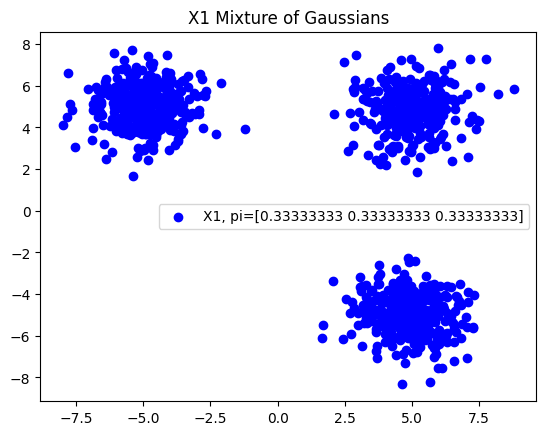

In [ ]:
mu_0 = np.array([[0, 0]])
K_0, d = mu_0.shape[0], mu_0.shape[1]
Sigma_0 = np.array([1.0]).reshape(K_0, 1)

pi_0 = np.ones((K_0, 1))/K_0

T=200


mu_1 = np.array([[5, 5], [5, -5], [-5, 5]])
K_1, d = mu_1.shape[0], mu_1.shape[1]
Sigma_1 = np.array([1.0, 1, 1]).reshape(K_1, 1)
pi_1 = np.ones((K_1, 1))/K_1
pi_1 = np.array([1/3, 1/3, 1/3]).reshape((K_1, 1))
cov1 = Sigma_1[:, :, np.newaxis] * np.eye(d)
print("Covariances of the X1 mixture: \n", cov1)

X_np = generate_mixture_samples(mu_1, cov1, pi_1.squeeze(), num_samples=1000)
plt.figure(1)
plt.scatter(X_np[:, 0], X_np[:, 1], label="X1, pi={}".format(pi_1.squeeze()), color="blue")
plt.title('X1 Mixture of Gaussians')
plt.legend()

In [ ]:
y = np.arange(0, 1, 0.01)
num_samples = y.shape[0]
Z_0 = np.ones((num_samples, d))
Z_0[:, 1] = y

trajectory, drift_save, weight_save = sample_rectified_flow(mu_0, mu_1, Sigma_0, Sigma_1, pi_0, pi_1, T=T)
indices = np.where(trajectory[0, :, 1]>0)[0]

indices.shape


(517,)

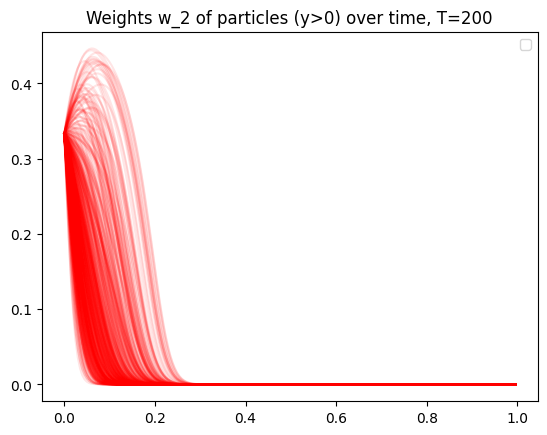

In [ ]:
plot_weights(weight_save, trajectory, 1)

Covariances of the X1 mixture: 
 [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


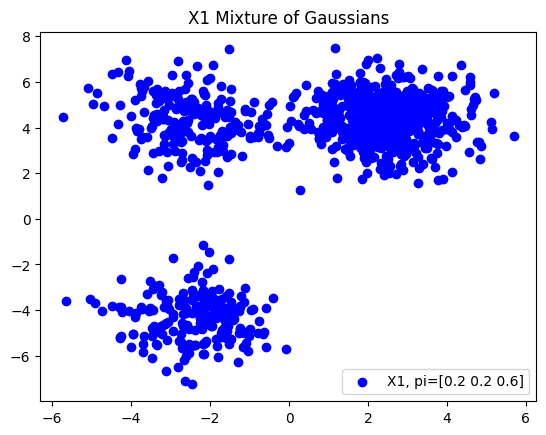

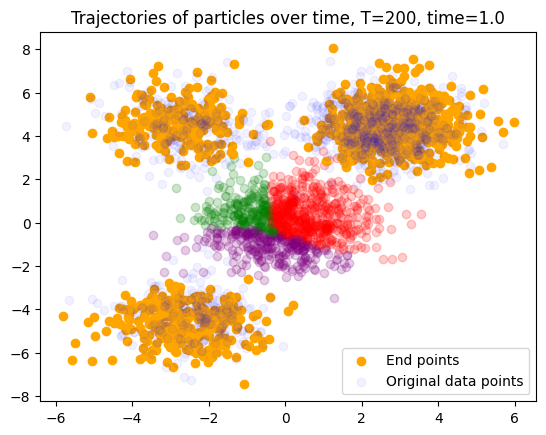

In [ ]:
from math import sqrt

mu_0 = np.array([[0, 0]])
K_0, d = mu_0.shape[0], mu_0.shape[1]
Sigma_0 = np.array([1.0]).reshape(K_0, 1)

pi_0 = np.ones((K_0, 1))/K_0

T=200


mu_1 = np.array([[-5/2, sqrt(3)*5/2], [-5/2, -sqrt(3)*5/2], [5/2, sqrt(3)*5/2]])
K_1, d = mu_1.shape[0], mu_1.shape[1]
Sigma_1 = np.array([1.0, 1, 1]).reshape(K_1, 1)
# pi_1 = np.ones((K_1, 1))/K_1
pi_1 = np.array([1/5, 1/5, 3/5]).reshape((K_1, 1))
cov1 = Sigma_1[:, :, np.newaxis] * np.eye(d)
print("Covariances of the X1 mixture: \n", cov1)

X_np = generate_mixture_samples(mu_1, cov1, pi_1.squeeze(), num_samples=1000)
plt.figure(1)
plt.scatter(X_np[:, 0], X_np[:, 1], label="X1, pi={}".format(pi_1.squeeze()), color="blue")
plt.title('X1 Mixture of Gaussians')
plt.legend()
plt.show()
plt.close()

y = np.arange(0, 1, 0.01)
num_samples = y.shape[0]
Z_0 = np.ones((num_samples, d))
Z_0[:, 1] = y

trajectory, drift_save, weight_save = sample_rectified_flow(mu_0, mu_1, Sigma_0, Sigma_1, pi_0, pi_1, T=T)
indices = np.where(trajectory[0, :, 1]>0)[0]

plot_trajectories(trajectory=trajectory, plot_paths=False, plot_original=True)

Covariances of the X1 mixture: 
 [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


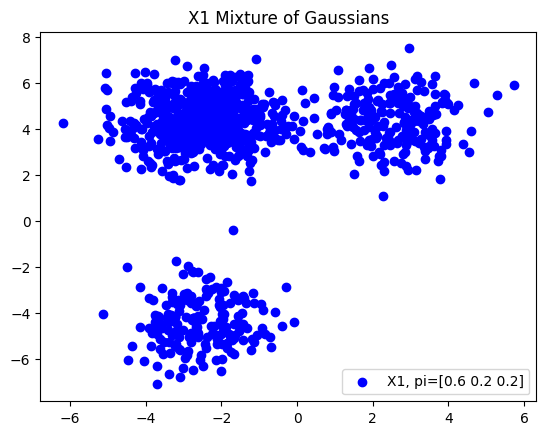

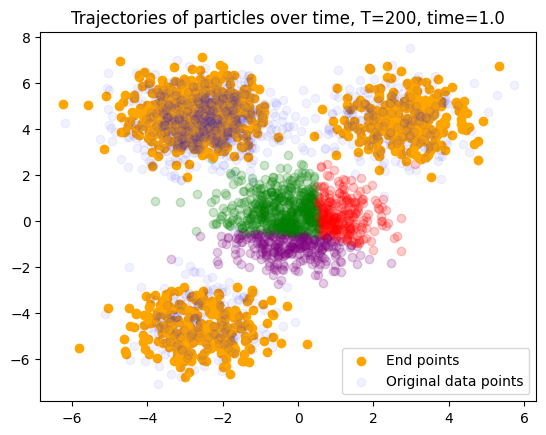

In [ ]:
from math import sqrt

mu_0 = np.array([[0, 0]])
K_0, d = mu_0.shape[0], mu_0.shape[1]
Sigma_0 = np.array([1.0]).reshape(K_0, 1)

pi_0 = np.ones((K_0, 1))/K_0

T=200


mu_1 = np.array([[-5/2, sqrt(3)*5/2], [-5/2, -sqrt(3)*5/2], [5/2, sqrt(3)*5/2]])
K_1, d = mu_1.shape[0], mu_1.shape[1]
Sigma_1 = np.array([1.0, 1, 1]).reshape(K_1, 1)
# pi_1 = np.ones((K_1, 1))/K_1
pi_1 = np.array([3/5, 1/5, 1/5]).reshape((K_1, 1))
cov1 = Sigma_1[:, :, np.newaxis] * np.eye(d)
print("Covariances of the X1 mixture: \n", cov1)

X_np = generate_mixture_samples(mu_1, cov1, pi_1.squeeze(), num_samples=1000)
plt.figure(1)
plt.scatter(X_np[:, 0], X_np[:, 1], label="X1, pi={}".format(pi_1.squeeze()), color="blue")
plt.title('X1 Mixture of Gaussians')
plt.legend()
plt.show()
plt.close()

y = np.arange(0, 1, 0.01)
num_samples = y.shape[0]
Z_0 = np.ones((num_samples, d))
Z_0[:, 1] = y

trajectory, drift_save, weight_save = sample_rectified_flow(mu_0, mu_1, Sigma_0, Sigma_1, pi_0, pi_1, T=T)
indices = np.where(trajectory[0, :, 1]>0)[0]

plot_trajectories(trajectory=trajectory, plot_paths=False, plot_original=True)

Covariances of the X1 mixture: 
 [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


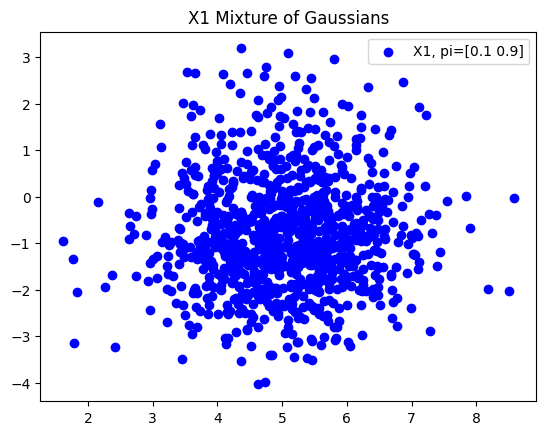

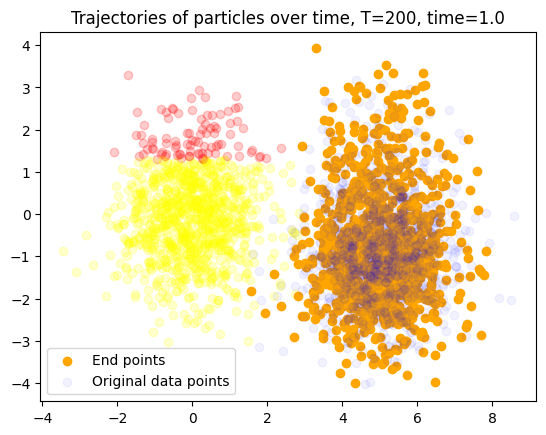

In [ ]:
from math import sqrt

mu_0 = np.array([[0, 0]])
K_0, d = mu_0.shape[0], mu_0.shape[1]
Sigma_0 = np.array([1.0]).reshape(K_0, 1)

pi_0 = np.ones((K_0, 1))/K_0

T=200


mu_1 = np.array([[5, 1], [5, -1]])
K_1, d = mu_1.shape[0], mu_1.shape[1]
Sigma_1 = np.array([1.0, 1]).reshape(K_1, 1)
# pi_1 = np.ones((K_1, 1))/K_1
pi_1 = np.array([0.1, 0.9]).reshape((K_1, 1))
cov1 = Sigma_1[:, :, np.newaxis] * np.eye(d)
print("Covariances of the X1 mixture: \n", cov1)

X_np = generate_mixture_samples(mu_1, cov1, pi_1.squeeze(), num_samples=1000)
plt.figure(1)
plt.scatter(X_np[:, 0], X_np[:, 1], label="X1, pi={}".format(pi_1.squeeze()), color="blue")
plt.title('X1 Mixture of Gaussians')
plt.legend()
plt.show()
plt.close()

y = np.arange(0, 1, 0.01)
num_samples = y.shape[0]
Z_0 = np.ones((num_samples, d))
Z_0[:, 1] = y

trajectory, drift_save, weight_save = sample_rectified_flow(mu_0, mu_1, Sigma_0, Sigma_1, pi_0, pi_1, T=T)
indices = np.where(trajectory[0, :, 1]>0)[0]

plot_trajectories(trajectory=trajectory, plot_paths=False, plot_original=True)

In [ ]:
def LDA_t(X, mu_1, Sigma_1, pi_1, i, j):
    (T, n, d) = X.shape
    K_1 = mu_1.shape[0]

    log_ratio = np.log(pi_1[i, 0] / pi_1[j, 0])
    print("log ratio: ", log_ratio)
    g_t = np.zeros((T, n))

    time = np.arange(T)/T
    time = time.reshape((T, 1, 1))

    norm_i = np.linalg.norm(X - time*mu_1[np.newaxis, i, :], axis=2)
    norm_j = np.linalg.norm(X - time*mu_1[np.newaxis, j, :], axis=2)

    print(time.shape)
    print(norm_i.shape)
    print(norm_j.shape)

    g_t = log_ratio - 0.5 * ((norm_i**2)/Sigma_1[i, 0] - (norm_j**2)/Sigma_1[j, 0])

    return g_t, log_ratio



log ratio:  2.197224577336219
(201, 1, 1)
(201, 1000)
(201, 1000)


array([-1.53039748,  0.26827509])

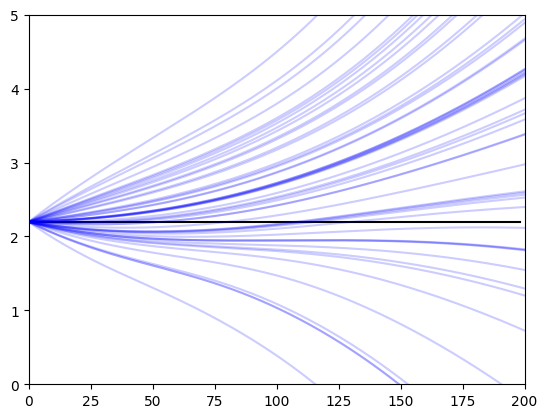

In [ ]:
g_01, log_ratio_01 = LDA_t(trajectory, mu_1, Sigma_1, pi_1, 1, 0)
# g_02 = g_t(trajectory, mu_1, Sigma_1, pi_1, 0, 2)
# g_12 = g_t(trajectory, mu_1, Sigma_1, pi_1, 1, 2)
x = np.arange(0, 1, 0.01)*200
plt.plot(x, log_ratio_01.repeat(x.shape[0]), color="black")
for i in range(0, g_01.shape[1], 20):
    plt.plot(g_01[:, i], color="blue", alpha=0.2)
    plt.xlim(0, 200)
    plt.ylim(0, 5)
# plt.plot(g_02[:, i], color="red")
# plt.plot(g_12[:, i], color="green")

trajectory[0, 100, :]

In [ ]:
print(trajectory[-1, :, :])

[[ 4.82095345 -3.55134084]
 [ 4.97805793 -0.17674432]
 [ 5.05236623 -0.05222835]
 ...
 [ 3.78891031 -0.32188256]
 [ 5.01176982 -2.17899253]
 [ 3.96990724 -0.08364033]]


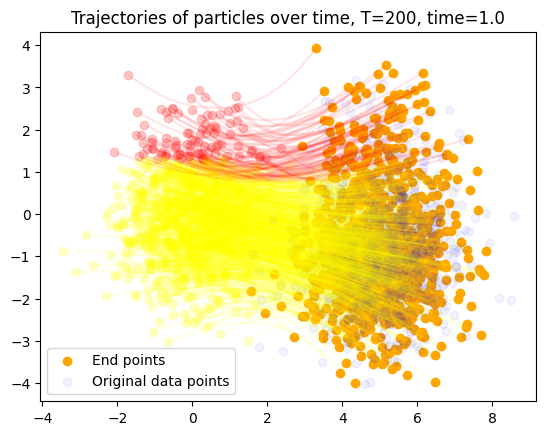

In [ ]:
plot_trajectories(trajectory=trajectory, plot_paths=True, plot_original=True)

0.911

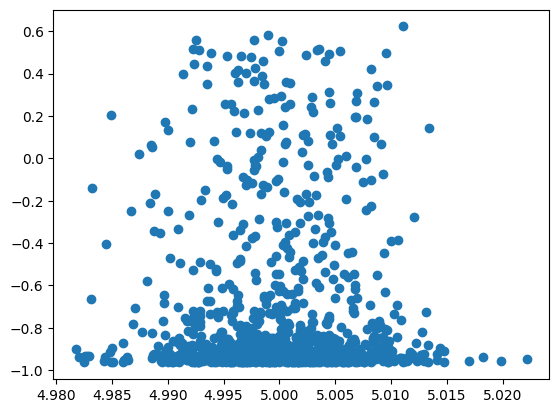

In [ ]:
X_rec_1, Z_rec_1 = trajectory[T, :, :], trajectory[0, :, :]

diff = X_rec_1 - Z_rec_1

plt.scatter(diff[:, 0], diff[:, 1])

np.sum(diff[:, 1]<0)/diff.shape[0]